In [1]:
import os
import sys

path_root = os.path.dirname(os.getcwd())

if path_root not in sys.path:
    sys.path.append(path_root)

In [2]:
import copy
import itertools
import json
from typing import List, Tuple, Any, Dict, Union

from src.config.experimental_config import (
    load_experimental_config,
    reload_as_experimental_config,
    ExperimentalConfig,
    SyntheaConfig,
    GenerateConfig,
    ExtractionConfig,
)
from src.config.global_config import load_global_config
from src.utils import save_json, load_json


class ExperimentalConfigHandler:
    def __init__(
        self, iter_overrides: dict = dict(), combine_overrides: dict = dict()
    ):
        """
        Initialize the ExperimentalConfigHandler.

        Args:
            iter_overrides (dict, optional): Overrides to define to override each experimental config. Defaults to dict().
            combine_overrides (dict, optional): Configuration to combine before iterating across the config. Defaults to dict().
        """
        self.iter_overrides = iter_overrides
        self.combine_overrides = combine_overrides
        self.experimental_configs = self.create_experimental_config_list()

    def create_experimental_config_list(
        self,
    ) -> Dict[
        str, List[Union[SyntheaConfig, GenerateConfig, ExtractionConfig]]
    ]:
        """
        Create a dictionary which holds all the unique configuration you need to run at each point.

        Returns:
            Dict[str, List[Union(SyntheaConfig, GenerateConfig, ExtractionConfig)]]
        """
        experimental_configs = generate_experimental_config_list(
            iter_overrides=self.iter_overrides,
            combine_overrides=self.combine_overrides,
        )

        synthea_list = list()
        generate_list = list()
        extraction_list = list()

        for config in experimental_configs:
            synthea_list.append(config.synthea)
            generate_list.append(config.generate)
            extraction_list.append(config.extraction)

        experimental_config_dict = {
            "synthea": remove_duplicates(synthea_list, SyntheaConfig),
            "generate": remove_duplicates(generate_list, GenerateConfig),
            "extraction": remove_duplicates(extraction_list, ExtractionConfig),
        }
        self.experimental_configs = (
            experimental_config_dict  # Update experimental_configs attribute
        )
        return experimental_config_dict

    def load_experimental_config(
        self, component_type: str
    ) -> List[Union[SyntheaConfig, GenerateConfig, ExtractionConfig]]:
        """
        Load experimental configs based on the specified component type.

        Args:
            component_type (str): The type of component to load.

        Returns:
            List[Union[SyntheaConfig, GenerateConfig, ExtractionConfig]]: List of experimental configs of the specified component type.
        """
        if component_type == "synthea":
            return self.experimental_configs["synthea"]
        elif component_type == "generate":
            return self.experimental_configs["generate"]
        elif component_type == "extraction":
            return self.experimental_configs["extraction"]
        else:
            raise ValueError(
                "Invalid component type. Must be synthea, generate, or extraction."
            )

    def update_iter_overrides(self, new_iter_overrides: dict):
        """
        Update the iter_overrides with new values. If a key already exists, append the value to a list.

        Args:
            new_iter_overrides (dict): New iter_overrides to update.
        """
        for key, value in new_iter_overrides.items():
            if key in self.iter_overrides:
                if isinstance(self.iter_overrides[key], list):
                    self.iter_overrides[key].append(value)
                else:
                    self.iter_overrides[key] = [
                        self.iter_overrides[key],
                        value,
                    ]
            else:
                self.iter_overrides[key] = value
        self.create_experimental_config_list()  # Update experimental config after updating iter_overrides

    def update_combine_overrides(self, new_combine_overrides: dict):
        """
        Update the combine_overrides with new values. If a key already exists, append the value to a list.

        Args:
            new_combine_overrides (dict): New combine_overrides to update.
        """
        for key, value in new_combine_overrides.items():
            if key in self.combine_overrides:
                if isinstance(self.combine_overrides[key], list):
                    self.combine_overrides[key].append(value)
                else:
                    self.combine_overrides[key] = [
                        self.combine_overrides[key],
                        value,
                    ]
            else:
                self.combine_overrides[key] = value
        self.create_experimental_config_list()  # Update experimental config after updating combine_overrides


def get_nested_keys_with_list(dictionary: dict):
    """
    Recursively construct a nested list of keys corresponding to nested dictionaries with list values.

    Args:
        dictionary (dict): The dictionary to traverse over.

    Returns:
        list: Nested list of keys for dictionaries with list values.
    """
    keys = []

    nested_list = []
    for key, value in dictionary.items():
        current_keys = keys + [key]
        if isinstance(value, dict):
            # If the value is a dictionary, recursively call the function
            nested_sublist = get_nested_keys_with_list(value, current_keys)
            if nested_sublist:
                # If the nested dictionary contains lists, append the current keys
                nested_list.extend(nested_sublist)
        elif isinstance(value, list):
            # If the value is a list, append the current keys
            nested_list.append(current_keys)

    return nested_list


def verify_keys_exist(config: ExperimentalConfig, overrides: dict):
    """
    Verify that keys in the dictionaries exist in the config.

    Args:
        config (ExperimentalConfig): The experimental pydantic config.
        overrides (dict): Dictionary of keys to iterate over.

    Raises:
        KeyError: If any key does not exist in the config.

    """
    for key, values in overrides.items():
        current_dict = config.model_dump()
        for subkey in key.split("."):
            if subkey in current_dict:
                current_dict = current_dict[subkey]
            else:
                raise KeyError(
                    f"The key '{subkey}' does not exist in the config."
                )


def verify_same_count(combine_overrides: dict):
    """
    Verify that keys that group together from their top level have the same count of items in their list.

    Args:
        combine_overrides (dict): Dictionary of keys to combine.

    Raises:
        ValueError: If keys that group together do not have the same count of items in their list.
    """
    group_counts = {}
    for key, values in combine_overrides.items():
        top_level_key = ".".join(key.split(".")[:-1])
        if top_level_key in group_counts:
            if group_counts[top_level_key] != len(values):
                raise ValueError(
                    f"The keys '{top_level_key}' do not have the same count of items in their list."
                )
        else:
            group_counts[top_level_key] = len(values)


def get_combination_overrides(combine_overrides: dict) -> List[dict]:
    """
    Creates a list of dictionaries to be combined from the combine_overrides.

    Args:
        combine_overrides (dict): This is a combine dictionary override which is a dictionary with keys corresponding to the experiment config.

    Returns:
        List[Tuple[dict]]: A List of dictionaries to be combined based on the combine_overrides given.

    """
    update_combine_config = []

    # Iterate over unique top-level keys
    for top_level_key in set(key.split(".")[0] for key in combine_overrides):
        top_level_override = {
            k: v
            for k, v in combine_overrides.items()
            if k.startswith(top_level_key)
        }
        # Counts how deeply nested a value, which is a list, for a given key.
        top_level_count = len(next(iter(top_level_override.values()), []))

        # Iterate over the indices of the top-level count
        for i in range(top_level_count):
            # Construct dictionary for current index
            add_dict = {}
            for k, v in top_level_override.items():
                if isinstance(v, list):
                    add_dict[k] = v[i]
                else:
                    add_dict[k] = v
            update_combine_config.append(add_dict)

    return update_combine_config


def combine_list_of_dictionaries(iter_comb: List[Tuple[dict]]) -> List[dict]:
    """
    Combine a list of dictionaries

    Args:
        iter_comb (list): A list of tuple dictionaries to be combined, where each dictionary only has one key - value pair.

    Returns:
        List[dict]: A list of combine dictionaries from each of the dictionaries that existed in the tuple.

    """
    combined_dicts = []
    for items in iter_comb:
        combined_dict = {}
        for item in items:
            combined_dict.update(item)
        combined_dicts.append(combined_dict)
    return combined_dicts


def get_iter_overrides(iter_overrides: dict) -> List[dict]:
    """
    Generate combinations of overrides from a dictionary.

    Args:
        iter_overrides (dict): A dictionary containing override values.

    Returns:
        list: A list of dictionaries representing combinations of override values.

    """
    update_iter_config = []

    for key, value in iter_overrides.items():
        if isinstance(value, list):
            inside_list = [{key: v} for v in value]
            update_iter_config.append(inside_list)
        else:
            update_iter_config.append([{key: value}])

    iter_comb = list(itertools.product(*update_iter_config))

    combined_dicts = combine_list_of_dictionaries(iter_comb)

    return combined_dicts


def create_total_combined_overrides(
    iter_overrides: dict, combine_overrides: dict
) -> List[dict]:
    """
    Generate total combined overrides by combining iteration and combination overrides.

    Args:
        iter_overrides (dict): A dictionary containing iteration overrides.
        combine_overrides (dict): A dictionary containing combination overrides.

    Returns:
        List[dict]: A list of dictionaries representing total combined overrides.

    """

    experimental_config = load_experimental_config()

    # Verify configs have the correct inputs requireed.
    verify_keys_exist(experimental_config, combine_overrides)
    verify_same_count(combine_overrides)

    # Creates a list of dictionaries to be combined from each overide type.
    comb_list = get_combination_overrides(combine_overrides)
    iter_list = get_iter_overrides(iter_overrides)

    if len(comb_list) == 0:
        total_comb = iter_list
    elif len(iter_list) == 0:
        total_comb = comb_list
    else:
        total_comb = list(itertools.product(*[iter_list, comb_list]))
        total_comb = combine_list_of_dictionaries(total_comb)

    clean_comb = correct_overrides_model_serving_type(total_comb)
    return clean_comb


def correct_overrides_model_serving_type(
    total_overrides: List[dict],
) -> List[dict]:
    """Function to correct for instances where you want to try various model_serving types with different values, but don't want complete iteration being copied.

    Args:
        total_overrides (List[dict]): List of total overrides you want to overwrite.

    Returns:
        List[dict]: Returns a list of ovverrides where None has been forced for some specific serving model vqriables.
    """
    configurations = copy.deepcopy(total_overrides)
    for config in configurations:
        if "extraction.server_model_type" in config.keys():
            if config["extraction.server_model_type"] != "gliner":
                config["extraction.gliner_features.gliner_model"] = None
            if config["extraction.server_model_type"] != "ollama":
                config["extraction.ollama_features.ollama_ner_model"] = None
                config["extraction.ollama_features.prompt_template_path"] = (
                    None
                )
            if config["extraction.server_model_type"] != "local":
                config["extraction.local_features.hf_repo_id"] = None
                config["extraction.local_features.hf_filename"] = None
                config["extraction.local_features.prompt_template_path"] = None

    return configurations


def create_paths_per_component_per_override(
    sub_override: dict,
) -> List[List[str]]:
    """
    Generate paths per component per override.

    Args:
        sub_override (dict): A dictionary containing an override dictionary for a specific combinations.

    Returns:
        List[List[str]]: A list containing paths per component per override.

    """
    synthea_features = get_component_features(
        sub_override, component_type="synthea"
    )
    generate_features = get_component_features(
        sub_override, component_type="generate"
    )
    extraction_features = get_component_features(
        sub_override, component_type="extraction"
    )

    synthea_paths = [synthea_features] if synthea_features else []
    generate_paths = (
        [synthea_features + "_" + generate_features]
        if generate_features
        else []
    )
    extraction_paths = (
        [
            synthea_features
            + "_"
            + generate_features
            + "_"
            + extraction_features
        ]
        if extraction_features
        else []
    )

    past_data_path = ["" if synthea_paths else "default"]

    synthea_paths = add_path_or_carry_through(
        past_data_paths=past_data_path, data_paths=synthea_paths
    )
    generate_paths = add_path_or_carry_through(
        past_data_paths=synthea_paths, data_paths=generate_paths
    )
    extraction_paths = add_path_or_carry_through(
        past_data_paths=generate_paths, data_paths=extraction_paths
    )

    return synthea_paths, generate_paths, extraction_paths


def get_component_features(overrides: dict, component_type: str) -> List[str]:
    """
    Extract component features based on component type from the given overrides.

    Args:
        overrides (dict): A dictionary containing override values.
        component_type (str): The type of component to extract features for.

    Returns:
        List[str]: A list of strings representing the extracted component features.
    """
    component_list = [
        f"{'_'.join(key.split('.')[1:])}_{value}"
        for key, value in overrides.items()
        if key.startswith(component_type)
    ]
    component_features = "_".join(component_list + [component_type])
    return component_features


def add_path_or_carry_through(
    data_paths: List[str], past_data_paths: List[str]
) -> List[str]:
    """
    Add paths or carry through existing paths based on the presence of data paths.

    Args:
        data_paths (List[str]): A list of data paths to be added.
        past_data_paths (List[str]): A list of past data paths to be carried through if no data paths are present.

    Returns:
        List[str]: A list of data paths with added paths or carried-through past data paths.

    """
    if len(data_paths) == 0:
        for path in past_data_paths:
            data_paths.append(path)

    return data_paths


def get_important_key_values(dict: Dict, component_type: str):
    return {
        key: value
        for key, value in dict.items()
        if (key.startswith(component_type) and value is not None)
    }


def get_path_and_output_from_config(path_dict: Dict, file_prefix: str):

    path_dict = copy.deepcopy(path_dict)
    output_dict = dict()

    for i, path in enumerate(path_dict.keys()):
        value = path_dict[path]
        path_dict[path] = f"{file_prefix}_{i}.json"
        output_dict[f"{file_prefix}_{i}"] = value

    return path_dict, output_dict


def create_path_and_output_dict(synthea_dict, generate_dict, extraction_dict):

    global_config = load_global_config()
    synthea_path, synthea_output = get_path_and_output_from_config(
        synthea_dict, global_config.output_paths.synthea_prefix
    )
    generate_path, generate_output = get_path_and_output_from_config(
        generate_dict, global_config.output_paths.generate_prefix
    )
    extraction_path, extraction_output = get_path_and_output_from_config(
        extraction_dict, global_config.output_paths.extraction_prefix
    )

    combined_path = {**synthea_path, **generate_path, **extraction_path}
    combined_output = {
        **synthea_output,
        **generate_output,
        **extraction_output,
    }
    return combined_path, combined_output


def create_and_save_data_paths(total_combined_overrides: List[dict]) -> str:
    """
    Create and save data paths based on combined overrides.

    Args:
        total_combined_overrides (List[dict]): A list of dictionaries representing total combined overrides.

    Returns:
        str: The path where the data paths are saved.

    """
    global_config = load_global_config()

    synthea_dict = dict()
    generate_dict = dict()
    extraction_dict = dict()

    for sub_override in total_combined_overrides:
        synthea_paths, generate_paths, extraction_paths = (
            create_paths_per_component_per_override(sub_override)
        )

        synthea_values = get_important_key_values(
            sub_override, component_type="synthea"
        )
        generate_values = get_important_key_values(
            sub_override, component_type="generate"
        )
        extraction_values = get_important_key_values(
            sub_override, component_type="extraction"
        )

        synthea_dict[synthea_paths[0]] = synthea_values
        generate_dict[generate_paths[0]] = generate_values
        extraction_dict[extraction_paths[0]] = extraction_values

    path_dict, output_dict = create_path_and_output_dict(
        synthea_dict, generate_dict, extraction_dict
    )

    experiment_name = total_combined_overrides[0]["outputs.experiment_name"]

    data_path = f"{global_config.output_paths.output_folder}/{experiment_name}/data_paths.json"
    save_json(data=output_dict, path=data_path)
    return path_dict


def update_experimental_config_value(
    key_string: str, experimental_config: dict, new_value: Any
):
    """Updates experimental config with value defined by the overrides combination produced.

    Args:
        key_string (str): This is the location of the value being change in the overrides.
        experimental_config (dict): This is the config that you want to rewrite values over onto.
        new_value (Any): This is the new value you want to the specific key string value you want to overwrite.
    """

    keys = key_string.split(".")
    current_experiment = experimental_config
    for key in keys[:-1]:
        current_experiment = current_experiment[key]
    current_experiment[keys[-1]] = new_value


def create_override_experimental_config(
    override: dict, data_paths: List[str]
) -> ExperimentalConfig:
    """
    Create an experimental configuration with overrides and data paths.

    Args:
        override (dict): A dictionary containing overrides to be applied to the experimental configuration.
        data_paths (List[str]): A list of data paths.

    Returns:
        ExperimentalConfig: The experimental configuration with applied overrides and data paths.

    """
    experimental_config = copy.deepcopy(
        load_experimental_config().model_dump()
    )
    global_config = load_global_config()

    for override_key, override_value in override.items():
        update_experimental_config_value(
            override_key, experimental_config, override_value
        )

    override_experiminetal_config = reload_as_experimental_config(
        experimental_config
    )

    synthea_paths, generate_paths, extraction_paths = (
        create_paths_per_component_per_override(override)
    )
    synthea_path = f"{global_config.output_paths.output_folder}/{global_config.output_paths.synthea_prefix}/{data_paths[synthea_paths[0]]}"
    generate_path = f"{global_config.output_paths.output_folder}/{global_config.output_paths.synthea_prefix}/{data_paths[generate_paths[0]]}"
    extraction_path = f"{global_config.output_paths.output_folder}/{global_config.output_paths.synthea_prefix}/{data_paths[extraction_paths[0]]}"

    override_experiminetal_config.synthea.path_output = synthea_path
    override_experiminetal_config.generate.synthea_path = synthea_path
    override_experiminetal_config.generate.path_output = generate_path
    override_experiminetal_config.extraction.llm_path = generate_path
    override_experiminetal_config.extraction.path_output = extraction_path

    return override_experiminetal_config


def generate_experimental_config_list(
    iter_overrides: dict = dict(), combine_overrides: dict = dict()
) -> List[ExperimentalConfig]:
    """
    Generate a list of experimental configurations based on iteration and combination overrides.

    Args:
        iter_overrides (dict, optional): A dictionary containing iteration overrides. Defaults to an empty dictionary.
        combine_overrides (dict, optional): A dictionary containing combination overrides. Defaults to an empty dictionary.

    Returns:
        List[ExperimentalConfig]: A list of experimental configurations.

    """
    total_combined_overrides = create_total_combined_overrides(
        iter_overrides=iter_overrides, combine_overrides=combine_overrides
    )

    data_paths = create_and_save_data_paths(total_combined_overrides)

    experimental_config_list = list()

    for i, override in enumerate(total_combined_overrides):
        override_config = create_override_experimental_config(
            override, data_paths
        )
        experimental_config_list.append(override_config)

    return experimental_config_list


def get_unique_dicts(
    configurations: List[Dict[str, Any]]
) -> List[Dict[str, Any]]:
    """
    Removes duplicate dictionaries from a list of dictionaries.

    Args:
        configurations (List[Dict[str, Any]]): List of dictionaries to be checked for duplicates.

    Returns:
        List[Dict[str, Any]]: List of unique dictionaries.
    """
    seen = set()
    result = []
    for d in configurations:
        # Convert dictionary to a string
        str_d = json.dumps(d, sort_keys=True)
        if str_d not in seen:
            seen.add(str_d)
            # Convert string back to dictionary
            result.append(json.loads(str_d))
    return result


def remove_duplicates(
    configurations: List[
        Union[SyntheaConfig, GenerateConfig, ExtractionConfig]
    ],
    pydantic_config: Union[SyntheaConfig, GenerateConfig, ExtractionConfig],
) -> List[Union[SyntheaConfig, GenerateConfig, ExtractionConfig]]:
    """
    Removes duplicate configurations based on their model dumps.

    Args:
        configurations (List[Union[SyntheaConfig, GenerateConfig, ExtractionConfig]]): List of configurations.
        pydantic_config (Union[SyntheaConfig, GenerateConfig, ExtractionConfig]): An instance of a Pydantic configuration model.

    Returns:
        List[Union[SyntheaConfig, GenerateConfig, ExtractionConfig]]: List of unique configurations.
    """
    # Convert models to dictionaries
    configuration_dicts = [config.model_dump() for config in configurations]

    # Get unique dictionaries
    unique_dicts = get_unique_dicts(configuration_dicts)

    # Convert unique dictionaries back to Pydantic models
    unique_configurations = [
        pydantic_config(**config) for config in unique_dicts
    ]

    return unique_configurations


def create_experimental_config_list(
    iter_overrides: dict = dict(), combine_overrides: dict = dict()
) -> Dict[str, List[Union[SyntheaConfig, GenerateConfig, ExtractionConfig]]]:
    """Create a dictionary which holds all the unique configuration you need to run at each point.

    Args:
        iter_overrides (dict, optional): This is the overrides you want to define to override each experimental config. Defaults to dict().
        combine_overrides (dict, optional): This is config you want to combine before iterating across the config. Defaults to dict().

    Returns:
        Dict[str, List[Union(SyntheaConfig, GenerateConfig, ExtractionConfig)]]
    """

    experimental_configs = generate_experimental_config_list(
        iter_overrides=iter_overrides, combine_overrides=combine_overrides
    )

    synthea_list = list()
    generate_list = list()
    extraction_list = list()

    for config in experimental_configs:
        synthea_list.append(config.synthea)
        generate_list.append(config.generate)
        extraction_list.append(config.extraction)

    experimental_config_dict = {
        "synthea": remove_duplicates(synthea_list, SyntheaConfig),
        "generate": remove_duplicates(generate_list, GenerateConfig),
        "extraction": remove_duplicates(extraction_list, ExtractionConfig),
    }

    return experimental_config_dict

# Creating Prompt Templates

In [ ]:
from src.config.prompt_template_handler import (
    save_extraction_template_to_json,
    save_generate_template_to_json,
    load_and_validate_extraction_prompt_template,
    load_and_validate_generate_prompt_template,
)

## Saving a prompt template Example for LLamma2

You will need to make sure that you generate template has a **{data}** insert defined.

In [ ]:
generate_template_path = (
    "../src/config/templates/generate/llama2_template.json"
)

generate_template = """[INST]
<<SYS>>
You are a medical student answering an exam question about writing clinical notes for patients.
<</SYS>>

Keep in mind that your answer will be asssessed based on incorporating all the provided information and the quality of prose.

1. Use prose to write an example clinical note for this patient's doctor.
2. Use less than three sentences.
3. Do not provide a recommendations.
4. Use the following information:

{data}
[/INST]
"""

save_generate_template_to_json(
    template_str=generate_template, file_path=generate_template_path
)

In [ ]:
loaded_generate_template = load_and_validate_generate_prompt_template(
    filename=generate_template_path
)
print(loaded_generate_template)

## Saving a UniversalNER prompt Example for Extraction

You will need to ensure your template has **{input_text}** and **{entity_name}** as a prompt template insert.

In [ ]:
extraction_template_path = (
    "../src/config/templates/extraction/universal_ner_template.json"
)

universalner_prompt_template = """
    USER: Text: {input_text}
    ASSISTANT: I’ve read this text.
    USER: What describes {entity_name} in the text?
    ASSISTANT: (model's predictions in JSON format)
    """

save_extraction_template_to_json(
    template_str=universalner_prompt_template,
    file_path=extraction_template_path,
)

In [ ]:
loaded_extraction_template = load_and_validate_extraction_prompt_template(
    filename=extraction_template_path
)
print(loaded_extraction_template)

# Privacy Fingerprint Experiment Pipeline

You will need to load the ExperimentalConfigHandler.


In [3]:
# from src.config.experimental_config_handler import ExperimentalConfigHandler

from src.generate.synthea import GenerateSynthea
from src.generate.llm import GenerateLLM
from src.extraction.extraction import Extraction

Then you need to define you overrides:

* **iter_overrides**: For components you want to override that are iterated across. Meaning you want each value to be compared to every other value that is defined.

* **combine_overrides**: Combine overrides is for users to define when they want to look at a combination of values, but not necesarrily iterate across all values. For example your specific llm model, might require a different prompt template.

In [4]:
# from src.config.experimental_config_handler import ExperimentalConfigHandler

iter_overrides = {
    "outputs.experiment_name": "experiment_0001_14_05_24",
    "synthea.population_num": ["2", "3", "4"],
    "extraction.server_model_type": ["gliner", "ollama", "local"],
}

combine_overrides = {
    # "extraction.gliner_features.gliner_model": ["urchade/gliner_medium-v2.1", "urchade/gliner_base"],
    # "extraction.ollama_features.ollama_ner_model": ["ollama1", "ollama2"],
    # "extraction.ollama_features.prompt_template_path": ["universalnerpath1", "universalnerpath2"],
    # "generate.llm_model_features.llm_model_name": ["llama2", "llama3"],
    # "generate.llm_model_features.prompt_template_path": ["llama2_template.json", "llama3_template.json"]
}

config_handler = ExperimentalConfigHandler(
    iter_overrides=iter_overrides, combine_overrides=combine_overrides
)

print("---- SyntheaConfig ----")
for config in config_handler.load_experimental_config("synthea"):
    print(config)

print("\n---- GenerateConfig ----")
for config in config_handler.load_experimental_config("generate"):
    print(config)

print("\n---- ExtractionConfig ----")
for config in config_handler.load_experimental_config("extraction"):
    print(config)

---- SyntheaConfig ----
population_num='2' county='West Yorkshire' path_output='../outputs/synthea/synthea_0.json'
population_num='3' county='West Yorkshire' path_output='../outputs/synthea/synthea_1.json'
population_num='4' county='West Yorkshire' path_output='../outputs/synthea/synthea_2.json'

---- GenerateConfig ----
llm_model_features=GenerateModelFeaturesConfig(llm_model_name='llama2', prompt_template_path='llama2_template.json') synthea_path='../outputs/synthea/synthea_0.json' path_output='../outputs/synthea/generate_0.json'
llm_model_features=GenerateModelFeaturesConfig(llm_model_name='llama2', prompt_template_path='llama2_template.json') synthea_path='../outputs/synthea/synthea_1.json' path_output='../outputs/synthea/generate_1.json'
llm_model_features=GenerateModelFeaturesConfig(llm_model_name='llama2', prompt_template_path='llama2_template.json') synthea_path='../outputs/synthea/synthea_2.json' path_output='../outputs/synthea/generate_2.json'

---- ExtractionConfig ----
serv

In [5]:
import math
import numpy as np


def get_relationships(config_handler):
    relationships = []

    for config in config_handler.load_experimental_config("generate"):
        synthea_path = config.synthea_path.split("/")[-1].split(".")[0]
        path_output = config.path_output.split("/")[-1].split(".")[0]
        relationships.append((synthea_path, path_output))

    for config in config_handler.load_experimental_config("extraction"):
        llm_path = config.llm_path.split("/")[-1].split(".")[0]
        path_output = config.path_output.split("/")[-1].split(".")[0]
        relationships.append((llm_path, path_output))

    return relationships


def get_connections_and_count(relationships):

    connections = dict()
    generate_count = 0
    extraction_count = 0
    synthea_paths = list(
        set(
            [
                path1
                for path1, path2 in relationships
                if path1.startswith("synthea")
            ]
        )
    )
    synthea_count = len(synthea_paths)

    for synthea_path in synthea_paths:
        generate_paths = [
            path2 for path1, path2 in relationships if path1 == synthea_path
        ]
        generate_count += len(generate_paths)
        inner_dict = dict()
        for generate_path in generate_paths:
            extraction_paths = [
                path2
                for path1, path2 in relationships
                if path1 == generate_path
            ]
            extraction_count += len(extraction_paths)
            inner_dict[generate_path] = extraction_paths

        connections[synthea_path] = inner_dict

    connections_count = {
        "synthea": synthea_count,
        "generate": generate_count,
        "extraction": extraction_count,
    }

    return connections, connections_count


def get_dag_positions(relationships):

    connections, connections_count = get_connections_and_count(relationships)

    extraction_num = (math.ceil(connections_count["extraction"] / 2)) * 2
    pos_list = [i for i in range(0, extraction_num, 2)]
    neg_list = [-1 * i for i in pos_list]
    if connections_count["extraction"] % 2 == 0:
        pos_list.append(connections_count["extraction"])
    extraction_list = pos_list[::-1] + neg_list[1:]
    extraction_tuples = [(2, val) for val in extraction_list]

    pos = dict()

    for synthea_path in connections.keys():
        generate_tuples = []
        for generate_path in connections[synthea_path].keys():
            extraction_paths = connections[synthea_path][generate_path]

            # Extract out the tuples for each extraction class
            sub_extraction_tuples = extraction_tuples[: len(extraction_paths)]
            extraction_tuples = extraction_tuples[len(extraction_paths) :]
            extraction_dict = dict(
                zip(extraction_paths, sub_extraction_tuples)
            )
            pos.update(extraction_dict)

            # Create your generate tuple location
            generate_tuple = (
                1,
                np.mean([val2 for _, val2 in sub_extraction_tuples]),
            )
            generate_tuples.append(generate_tuple)
            pos[generate_path] = generate_tuple

        # Create your synthea tuples
        synthea_tuple = (0, np.mean([val2 for _, val2 in generate_tuples]))
        pos[synthea_path] = synthea_tuple

    figsize_h = connections_count["extraction"]

    return pos, figsize_h


relationships = get_relationships(config_handler)
pos = get_dag_positions(relationships)

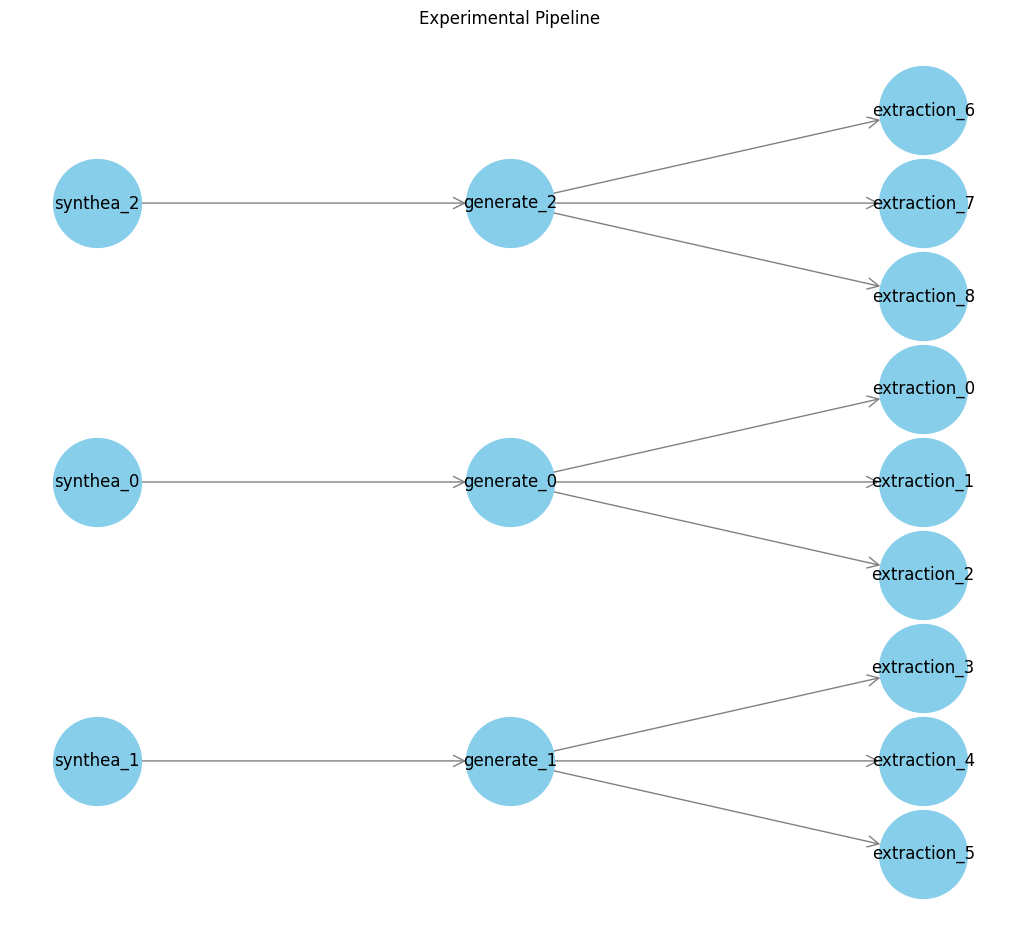

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import mplcursors


# Function to draw the graph
def draw_graph(config_handler):
    relationships = get_relationships(config_handler)
    positions, figsize_height = get_dag_positions(relationships)

    # Create a directed graph
    G = nx.DiGraph()
    G.add_edges_from(relationships)

    if figsize_height < 6:
        figsize_height = 6

    # Draw the graph
    plt.figure(figsize=(10, figsize_height))
    nx.draw(
        G,
        positions,
        with_labels=True,
        node_color="skyblue",
        edge_color="gray",
        node_size=4000,
        arrowstyle="->",
        arrowsize=20,
    )
    plt.title("Experimental Pipeline")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


# Example usage

draw_graph(config_handler)

In [7]:
relationships = get_relationships(config_handler)
positions, figsize_height = get_dag_positions(relationships)

In [9]:
output_path = "../outputs/experiment_0001_14_05_24/data_paths.json"
data_paths = load_json(output_path)
data_paths

{'synthea_0.json': {'synthea.population_num': '2'},
 'synthea_1.json': {'synthea.population_num': '3'},
 'synthea_2.json': {'synthea.population_num': '4'},
 'generate_0.json': {},
 'generate_1.json': {},
 'generate_2.json': {},
 'extraction_0.json': {'extraction.server_model_type': 'gliner'},
 'extraction_1.json': {'extraction.server_model_type': 'ollama'},
 'extraction_2.json': {'extraction.server_model_type': 'local'},
 'extraction_3.json': {'extraction.server_model_type': 'gliner'},
 'extraction_4.json': {'extraction.server_model_type': 'ollama'},
 'extraction_5.json': {'extraction.server_model_type': 'local'},
 'extraction_6.json': {'extraction.server_model_type': 'gliner'},
 'extraction_7.json': {'extraction.server_model_type': 'ollama'},
 'extraction_8.json': {'extraction.server_model_type': 'local'}}

In [11]:
import plotly.graph_objects as go
import networkx as nx


def draw_graph(config_handler, flipped_paths):
    relationships = get_relationships(config_handler)
    positions, figsize_height = get_dag_positions(relationships)

    # Create a directed graph
    G = nx.DiGraph()
    G.add_edges_from(relationships)

    # Extract node positions and names
    node_x = []
    node_y = []
    node_text = []
    hover_text = []
    for node, pos in positions.items():
        x, y = pos
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)  # Use the original node name for text labels
        hover_text.append(
            flipped_paths.get(node, "")
        )  # Use flipped_paths dictionary for hover text

    # Extract edge positions
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = positions[edge[0]]
        x1, y1 = positions[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)  # None separates the segments
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    # Create edge trace
    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=1, color="gray"),
        hoverinfo="none",
        mode="lines",
    )

    # Create node trace
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers+text",
        text=node_text,  # Use node names for text labels
        textposition="top center",
        hovertext=hover_text,  # Use flipped_paths for hover text
        hoverinfo="text",
        marker=dict(showscale=False, color="skyblue", size=10, line_width=2),
    )

    # Create the figure
    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            title="Experimental Pipeline",
            titlefont_size=16,
            showlegend=False,
            hovermode="closest",
            margin=dict(b=20, l=5, r=5, t=40),
            annotations=[
                dict(
                    text="",
                    showarrow=False,
                    xref="paper",
                    yref="paper",
                    x=0.005,
                    y=-0.002,
                )
            ],
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(
                showgrid=True,
                zeroline=False,
                gridcolor="lightgray",
                gridwidth=0.5,
                tickvals=[
                    i for i in range(int(min(node_y)), int(max(node_y)) + 1)
                ],
            ),
        ),
    )

    fig.show()


draw_graph(config_handler, flipped_paths)

NameError: name 'flipped_paths' is not defined

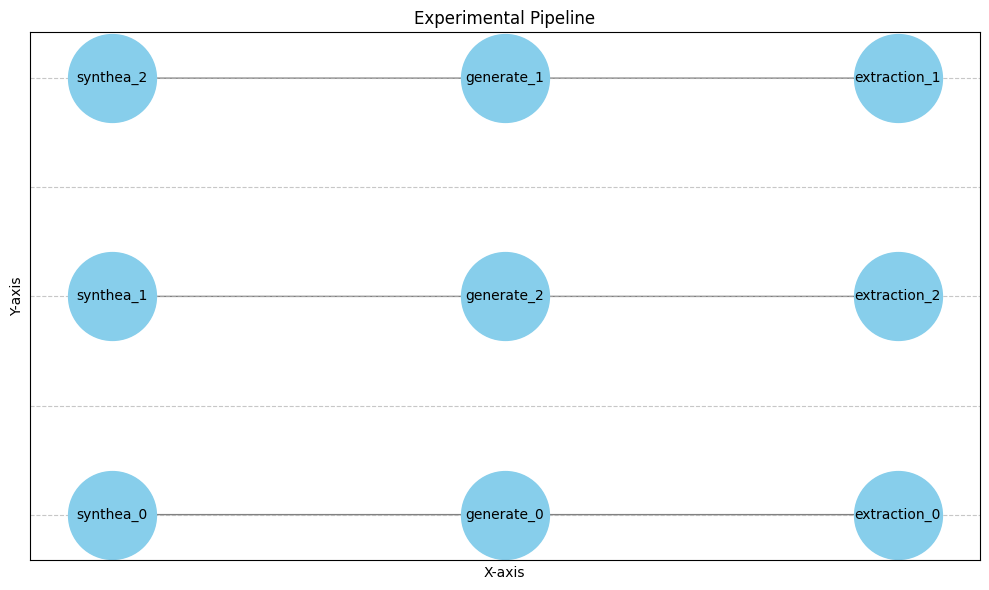

In [8]:
def draw_graph(config_handler):
    relationships = get_relationships(config_handler)
    positions, figsize_height = get_dag_positions(relationships)

    # Create a directed graph
    G = nx.DiGraph()
    G.add_edges_from(relationships)

    if figsize_height < 6:
        figsize_height = 6

    # Draw the graph
    plt.figure(figsize=(10, figsize_height))
    nodes = nx.draw_networkx_nodes(
        G, positions, node_color="skyblue", node_size=4000
    )
    edges = nx.draw_networkx_edges(
        G, positions, arrowstyle="->", arrowsize=20, edge_color="gray"
    )
    labels = nx.draw_networkx_labels(
        G, positions, font_size=10, font_color="black"
    )
    plt.title("Experimental Pipeline")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Add hover tips
    cursor = mplcursors.cursor(nodes, hover=True)

    @cursor.connect("add")
    def on_add(sel):
        node_index = sel.index
        node_label = list(G.nodes)[node_index]
        sel.annotation.set(
            text=node_label, position=(0, 20), textcoords="offset points"
        )

    plt.show()


draw_graph(config_handler)

## 1. GenerateSynthea: Generating Synthetic Patient Data using Synthea 

In [7]:
for i, synthea_config in enumerate(
    config_handler.load_experimental_config("synthea")
):
    print(f"Synthea Run {i} with config {synthea_config}")
    synthea_output = GenerateSynthea(
        syntheaconfig=synthea_config
    ).run_or_load()
    print(synthea_output, "\n")

Synthea Run 0 with config population_num='50' county='West Yorkshire' path_output='../outputs/synthea/synthea_0.json'
[{'NHS_NUMBER': '4313129332', 'DATE_OF_BIRTH': '2010-05-27', 'GIVEN_NAME': 'Laurice', 'FAMILY_NAME': 'Jast', 'DIAGNOSIS': 'Otitis media'}, {'NHS_NUMBER': '0998965049', 'DATE_OF_BIRTH': '1992-07-06', 'GIVEN_NAME': 'Terrilyn', 'FAMILY_NAME': "D'Amore", 'DIAGNOSIS': 'Normal pregnancy'}, {'NHS_NUMBER': '2019798026', 'DATE_OF_BIRTH': '1969-06-15', 'GIVEN_NAME': 'Garfield', 'FAMILY_NAME': 'Wiza', 'DIAGNOSIS': 'Appendicitis'}, {'NHS_NUMBER': '2517453667', 'DATE_OF_BIRTH': '1964-12-22', 'GIVEN_NAME': 'Neville', 'FAMILY_NAME': 'Gusikowski', 'DIAGNOSIS': 'Osteoarthritis of hip'}, {'NHS_NUMBER': '0605852235', 'DATE_OF_BIRTH': '1980-04-24', 'GIVEN_NAME': 'Lovella', 'FAMILY_NAME': 'Rogahn', 'DIAGNOSIS': 'Viral sinusitis (disorder)'}, {'NHS_NUMBER': '9205610801', 'DATE_OF_BIRTH': '1974-01-12', 'GIVEN_NAME': 'Melvin', 'FAMILY_NAME': 'Kreiger', 'DIAGNOSIS': 'Childhood asthma'}, {'NHS_N

## 2. GenerateLLM: Generating Synthetic Patient Medical Notes 

In [8]:
for i, generate_config in enumerate(
    config_handler.load_experimental_config("generate")
):
    print(f"Generate Run {i} with config {generate_config}")
    generate_output = GenerateLLM(generateconfig=generate_config).run_or_load()
    print(generate_output, "\n")

Generate Run 0 with config llm_model_features=GenerateModelFeaturesConfig(llm_model_name='llama2', prompt_template_path='llama2_template.json') synthea_path='../outputs/synthea/synthea_0.json' path_output='../outputs/synthea/generate_0.json'
['Clinical Note:\n\nPatient: Laurice Jast\nNHS Number: 4313129332\nDate of Birth: May 27, 2010\n\nDiagnosis: Otitis media\n\nPresenting symptoms: Ear pain, fever, difficulty sleeping.', "Clinical Note:\nPatient: Terrilyn D'Amore\nNHS Number: 0998965049\nDate of Birth: July 6, 1992\n\nPresenting Complaint: Normal pregnancy\n\nReview of Systems: No abnormalities identified.", 'Clinical Note:\n\nPatient: Garfield Wiza\nNHS Number: 2019798026\nDate of Birth: June 15, 1969\n\nDIAGNOSIS: Appendicitis\n\nChief Complaint: Right lower quadrant abdominal pain, nausea, vomiting for the past 24 hours. Patient has a history of similar episodes in the past.', "Clinical Note:\n\nPatient Name: Neville Gusikowski\nNHS Number: 2517453667\nDate of Birth: December 22,

## 3. Extraction: Re-extracting Entities from the Patient Medical Notes

In [11]:
for i, extraction_config in enumerate(
    config_handler.load_experimental_config("extraction")
):
    print(f"Extraction Run {i} with config {extraction_config}")
    extraction_output = Extraction(
        extractionconfig=extraction_config
    ).run_or_load()
    print(extraction_output, "\n")

Extraction Run 0 with config server_model_type='gliner' gliner_features=GlinerFeaturesConfig(gliner_model='urchade/gliner_medium-v2.1') local_features=LocalFeaturesConfig(hf_repo_id=None, hf_filename=None, prompt_template_path=None) ollama_features=OllamaFeaturesConfig(ollama_ner_model=None, prompt_template_path=None) entity_list=['person', 'date of bith', 'nhs number', 'diagnosis'] llm_path='../outputs/synthea/generate_0.json' path_output='../outputs/synthea/extraction_1.json'
[{'Entities': [{'start': 25, 'end': 37, 'text': 'Laurice Jast', 'label': 'person', 'score': 0.9355241060256958}, {'start': 38, 'end': 48, 'text': 'NHS Number', 'label': 'nhs number', 'score': 0.7496670484542847}, {'start': 50, 'end': 60, 'text': '4313129332', 'label': 'nhs number', 'score': 0.9242134094238281}, {'start': 76, 'end': 88, 'text': 'May 27, 2010', 'label': 'date of bith', 'score': 0.8938113451004028}, {'start': 101, 'end': 113, 'text': 'Otitis media', 'label': 'diagnosis', 'score': 0.9681205749511719